In [1]:
#Import all the neccessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import openpyxl
import pandas as pd
import seaborn as sns


In [2]:
#Copying current content to new editable directory

!cp -r "/home/mayssa/deepleerning" 

#Selecting dataset directory


ds_asl_dir = "/home/mayssa/deepleerning/asl_dataset"
#Generating a dataset

asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

cp: missing destination file operand after '/home/mayssa/deepleerning'
Try 'cp --help' for more information.
Found 2515 files belonging to 36 classes.


In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

#Listing directory. You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

!ls "/home/mayssa/deepleerning/asl_dataset"

#Showing index + class

pd.DataFrame(asl_ds.class_names)

0  2  4  6  8  a  c  e	g  i  k  m  o  q  s  u	w  y
1  3  5  7  9  b  d  f	h  j  l  n  p  r  t  v	x  z


In [10]:
#Checking images and labels shapes (amount of images, height, width, color channels)

for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [3]:
#Displaying some picture´s size

from PIL import Image
img =  Image.open("/home/mayssa/deepleerning/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

Image sample with width=400 and height=400.


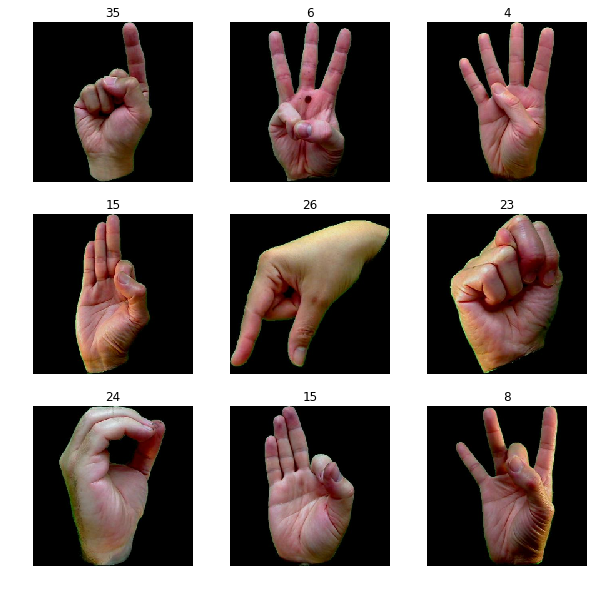

In [12]:
#Displaying image samples

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
#Defining parameters for the loader

batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [6]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

In [7]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])



In [8]:
#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau 
#Import callback functions
earlystop=EarlyStopping(patience=10) 
#Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_acc",min_lr=0.001) 
#Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]



In [17]:
model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=40)

Epoch 1/40
63/63 [==============================] - 14s 206ms/step - loss: 3.5018 - accuracy: 0.0497 - val_loss: 3.1954 - val_accuracy: 0.1392 - lr: 0.0010
Epoch 2/40
63/63 [==============================] - 9s 149ms/step - loss: 2.8587 - accuracy: 0.1590 - val_loss: 2.5013 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 3/40
63/63 [==============================] - 9s 150ms/step - loss: 2.3592 - accuracy: 0.2679 - val_loss: 1.9730 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 4/40
63/63 [==============================] - 10s 152ms/step - loss: 2.0377 - accuracy: 0.3504 - val_loss: 1.6673 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 5/40
63/63 [==============================] - 10s 164ms/step - loss: 1.7836 - accuracy: 0.4115 - val_loss: 1.4821 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 6/40
63/63 [==============================] - 10s 156ms/step - loss: 1.6298 - accuracy: 0.4573 - val_loss: 1.2796 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 7/40
63/63 [==============================] - 9s 148ms/step 

63/63 [==============================] - 10s 163ms/step - loss: 0.7612 - accuracy: 0.7242 - val_loss: 0.5879 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 22/40
63/63 [==============================] - 10s 164ms/step - loss: 0.7950 - accuracy: 0.7058 - val_loss: 0.6345 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 23/40
63/63 [==============================] - 10s 154ms/step - loss: 0.7333 - accuracy: 0.7192 - val_loss: 0.5990 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 24/40
63/63 [==============================] - 10s 155ms/step - loss: 0.7213 - accuracy: 0.7251 - val_loss: 0.5739 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 25/40
63/63 [==============================] - 10s 161ms/step - loss: 0.6653 - accuracy: 0.7580 - val_loss: 0.4799 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 26/40
63/63 [==============================] - 10s 166ms/step - loss: 0.7385 - accuracy: 0.7187 - val_loss: 0.5148 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 27/40
63/63 [==============================] - 10s 166ms/step - 

In [9]:
#Saving the model

model_dl.save("model_dl.h5")

#Loading themodel

model_dl = keras.models.load_model("model_dl.h5") #look for local saved file

In [19]:
#We´ll use any image sample from the Kaggle dataset to test it 

from keras.preprocessing import image

#Creating a dictionary to map each of the indexes to the corresponding number or letter

dict = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",
        17:"h",18:"i",19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",28:"s",29:"t",30:"u",31:"v",32:"w",
        33:"x",34:"y",35:"z"}

#Predicting images

img = image.load_img("/home/mayssa/deepleerning/asl_dataset/a/hand1_a_bot_seg_1_cropped.jpeg", target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
predict_x=model_dl.predict(image) 
classes=np.argmax(predict_x,axis=1)
def predict_prob(number):
  return [number[0],1-number[0]]

probabilities = np.array(list(map(predict_prob, model_dl.predict(image))))
probabilities_formatted = list(map("{:.2f}%".format, probabilities[0]*100))

print(classes) #displaying matrix prediction position

print(probabilities_formatted)

[32]
['0.00%', '100.00%']


In [12]:
print(f'The predicted image corresponds to "{dict[classes.item()]}"') #displaying matrix prediction position name (number or letter)

The predicted image corresponds to "w"
